# Distributions of nodes and edges in MoA-net

In [1]:
import os
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

# Load networks

In [2]:
KG_DIR = '../data/kg'
SPLITS_DIR = os.path.join(KG_DIR, 'splits')
MoA_net_DIR = os.path.join(SPLITS_DIR, 'MoA-net')
MoA_subclassed_DIR = os.path.join(SPLITS_DIR, 'MoA-net-protclass')
FIG_DIR = '../figures'
os.makedirs(FIG_DIR, exist_ok=True)

In [3]:
kg = pd.read_csv(f'{MoA_net_DIR}/kg_with_train_smpls.tsv', sep='\t')
kg.drop_duplicates(inplace=True)
kg.head(2)

,source,source_node_type,target,target_node_type,edge_type
0,ncbigene:5602,Gene,ncbigene:2354,Gene,interacts
1,ncbigene:8021,Gene,ncbigene:6430,Gene,interacts


In [4]:
kg_p = pd.read_csv(f'{MoA_subclassed_DIR}/kg_with_train_smpls.tsv', sep='\t')
kg_p.drop_duplicates(inplace=True)
kg_p.head(2)

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:6167,Compound,ncbigene:3371,Gene,upregulates
1,ncbigene:4303,Developmental protein,ncbigene:359,Gene,interacts


# Get basic stats

In [5]:
kg.edge_type.value_counts()

edge_type
interacts        86786
participates      4325
downregulates     2205
upregulates       1631
induces            986
Name: count, dtype: int64

In [6]:
kg_p.edge_type.value_counts()

edge_type
interacts        78617
participates      5027
downregulates     2486
upregulates       1949
induces            986
Name: count, dtype: int64

# Get node counts

In [7]:
drugs = set()
proteins = set()
bps = set()

for source, target in tqdm(kg[['source', 'target']].values):
    if source.startswith('pubchem.compound:'):
        drugs.add(source)
    elif source.startswith('ncbigene:'):
        proteins.add(source)
    else:
        raise ValueError(f'Unknown source: {source}')

    if target.startswith('pubchem.compound:'):
        drugs.add(target)
    elif target.startswith('ncbigene:'):
        proteins.add(target)
    elif target.startswith('GO:'):
        bps.add(target)
    else:
        raise ValueError(f'Unknown target: {target}')

100%|██████████| 95933/95933 [00:00<00:00, 478774.53it/s]


In [8]:
drugs_p = set()
proteins_p = set()
bps_p = set()

for source, target in tqdm(kg_p[['source', 'target']].values):
    if source.startswith('pubchem.compound:'):
        drugs_p.add(source)
    elif source.startswith('ncbigene:'):
        proteins_p.add(source)
    else:
        raise ValueError(f'Unknown source: {source}')

    if target.startswith('pubchem.compound:'):
        drugs_p.add(target)
    elif target.startswith('ncbigene:'):
        proteins_p.add(target)
    elif target.startswith('GO:'):
        bps_p.add(target)
    else:
        raise ValueError(f'Unknown target: {target}')

100%|██████████| 89065/89065 [00:00<00:00, 449990.23it/s]


### Get edges counts

In [9]:
relations = dict(kg.edge_type.value_counts())
print(relations)

{'interacts': 86786, 'participates': 4325, 'downregulates': 2205, 'upregulates': 1631, 'induces': 986}


In [10]:
relations_p = dict(kg_p.edge_type.value_counts())
print(relations_p)

{'interacts': 78617, 'participates': 5027, 'downregulates': 2486, 'upregulates': 1949, 'induces': 986}


In [11]:
drug_protein = relations['downregulates'] + relations['upregulates']
protein_protein = relations['interacts']
protein_bps = relations['participates']
drug_bps = relations['induces']

In [12]:
drug_protein_p = relations_p['downregulates'] + relations_p['upregulates']
protein_protein_p = relations_p['interacts']
protein_bps_p = relations_p['participates']
drug_bps_p = relations_p['induces']

## Summary stats

MoA-net:

In [13]:
print('##### Number of nodes in MoA-net #####')
print(f'{len(drugs)}: # of unique drugs')
print(f'{len(proteins)}: # of unique proteins')
print(f'{len(bps)}: # of unique biological processes')

print('\n##### Number of edges in MoA-net ######')       
print(f'{len(kg)}: total # of interactions')
print(f'{drug_protein}: # of drug-protein interactions')
print(f'{protein_protein}: # of protein-protein interactions')
print(f'{protein_bps}: # of protein-process interactions')
print(f'{drug_bps}: # of drug-process interactions')

##### Number of nodes in MoA-net #####
300: # of unique drugs
9301: # of unique proteins
86: # of unique biological processes

##### Number of edges in MoA-net ######
95933: total # of interactions
3836: # of drug-protein interactions
86786: # of protein-protein interactions
4325: # of protein-process interactions
986: # of drug-process interactions


Protein-classed MoA-net:

In [14]:
print('##### Number of nodes in MoA-net #####')
print(f'{len(drugs_p)}: # of unique drugs')
print(f'{len(proteins_p)}: # of unique proteins')
print(f'{len(bps_p)}: # of unique biological processes')

print('\n##### Number of edges in MoA-net ######')       
print(f'{len(kg_p)}: total # of interactions')
print(f'{drug_protein_p}: # of drug-protein interactions')
print(f'{protein_protein_p}: # of protein-protein interactions')
print(f'{protein_bps_p}: # of protein-process interactions')
print(f'{drug_bps_p}: # of drug-process interactions')

##### Number of nodes in MoA-net #####
300: # of unique drugs
6833: # of unique proteins
86: # of unique biological processes

##### Number of edges in MoA-net ######
89065: total # of interactions
4435: # of drug-protein interactions
78617: # of protein-protein interactions
5027: # of protein-process interactions
986: # of drug-process interactions


# Plot distributions of nodes

### MoA-net:

In [15]:
data_nodes = {
    'Count':[
        len(drugs),
        len(proteins), 
        len(bps), 
    ],
    'Node Types':['Drugs','Genes/Proteins','Biological Processes']
}

node_df = pd.DataFrame(data=data_nodes)
node_df.head()

,Count,Node Types
0,300,Drugs
1,9301,Genes/Proteins
2,86,Biological Processes


In [16]:
predicates = {'interacts': 'interacts\n(Protein, Protein)',
 'participates': 'participates\n(Protein, BP)',
 'downregulates': 'downregulates\n(Drug, Protein)',
 'upregulates': 'upregulates\n(Drug, Protein)',
 'induces': 'induces\n(Drug, BP)'}

In [17]:
relations = {predicates[key]: val for key, val in relations.items()}

In [18]:
# Convert dictionary items to a list of tuples
data_list = [(key, value) for key, value in relations.items()]

# Create a DataFrame from the list of tuples
edges_df = pd.DataFrame(data_list, columns=['Edge Types', 'Count'])
edges_df

,Edge Types,Count
0,"interacts\n(Protein, Protein)",86786
1,"participates\n(Protein, BP)",4325
2,"downregulates\n(Drug, Protein)",2205
3,"upregulates\n(Drug, Protein)",1631
4,"induces\n(Drug, BP)",986


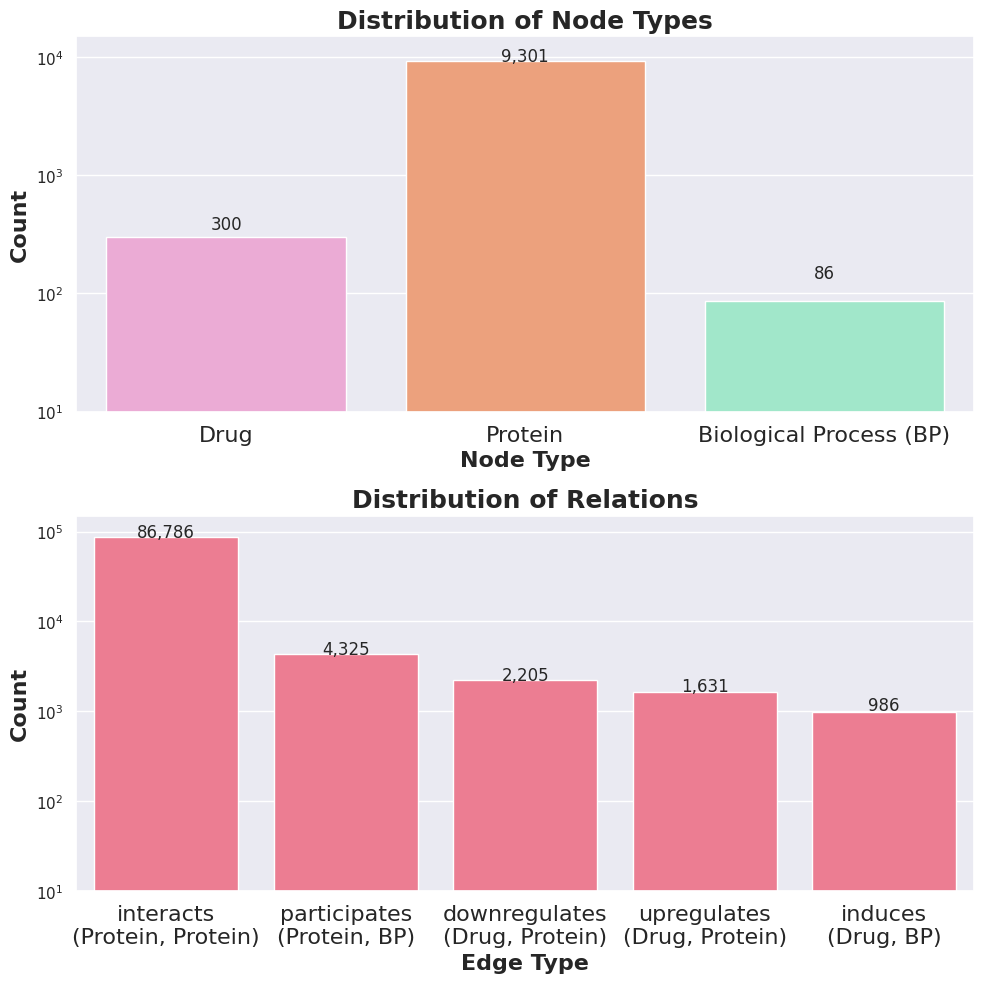

In [19]:
sns.set(rc={'figure.figsize':(10,10)})

# grid lines
sns.set_style("darkgrid")

plt.subplot(2, 1, 1)
bx1 = sns.barplot(
    x="Node Types", y="Count", data=node_df,
    palette=['#F6A0D8','#FE9A6B', '#95F3CC']
) 
plt.title(
    'Distribution of Node Types', 
    fontsize=18, 
    fontweight="bold"
)
plt.xlabel("Node Type", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.xticks(bx1.get_xticks(), labels=['Drug', 'Protein', 'Biological Process (BP)'], fontsize=16)
plt.ylim(10, 15000)
plt.yscale("log") #the log transformation

for p in bx1.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    bx1.text(_x, _y, f'{value:,}', ha="center") 

plt.subplot(2, 1, 2)
bx2 = sns.barplot(
    x="Edge Types", y="Count", data=edges_df, 
    color='#fe6b86'
)
plt.title(
    'Distribution of Relations', 
    fontsize=18, 
    fontweight="bold"
)
plt.xlabel("Edge Type", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold") 
plt.xticks(bx2.get_xticks(), labels=list(edges_df['Edge Types']), fontsize=16)
plt.ylim(10, 150000)

plt.yscale("log") #the log transformation

# Add counts above bars
for p in bx2.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    bx2.text(_x, _y, f'{value:,}', ha="center")   


plt.tight_layout()
plt.savefig(
    f'{FIG_DIR}/graph-stats.png',
    dpi=400,
    bbox_inches='tight', 
)
plt.show()

In [20]:
ratio_interacts = edges_df.loc[edges_df['Edge Types']=='interacts\n(Protein, Protein)']['Count'].sum() / edges_df['Count'].sum()
ratio_interacts

0.9046522051848686

### Protein-classed MoA-net:

In [21]:
data_nodes = {
    'Count':[
        len(drugs_p),
        len(proteins_p), 
        len(bps_p), 
    ],
    'Node Types':['Drugs','Genes/Proteins','Biological Processes']
}

node_df = pd.DataFrame(data=data_nodes)
node_df.head()

,Count,Node Types
0,300,Drugs
1,6833,Genes/Proteins
2,86,Biological Processes


In [22]:
predicates = {'interacts': 'interacts\n(Protein, Protein)',
 'participates': 'participates\n(Protein, BP)',
 'downregulates': 'downregulates\n(Drug, Protein)',
 'upregulates': 'upregulates\n(Drug, Protein)',
 'induces': 'induces\n(Drug, BP)'}

In [23]:
relations = {predicates[key]: val for key, val in relations_p.items()}

In [24]:
# Convert dictionary items to a list of tuples
data_list = [(key, value) for key, value in relations.items()]

# Create a DataFrame from the list of tuples
edges_df = pd.DataFrame(data_list, columns=['Edge Types', 'Count'])
edges_df

,Edge Types,Count
0,"interacts\n(Protein, Protein)",78617
1,"participates\n(Protein, BP)",5027
2,"downregulates\n(Drug, Protein)",2486
3,"upregulates\n(Drug, Protein)",1949
4,"induces\n(Drug, BP)",986


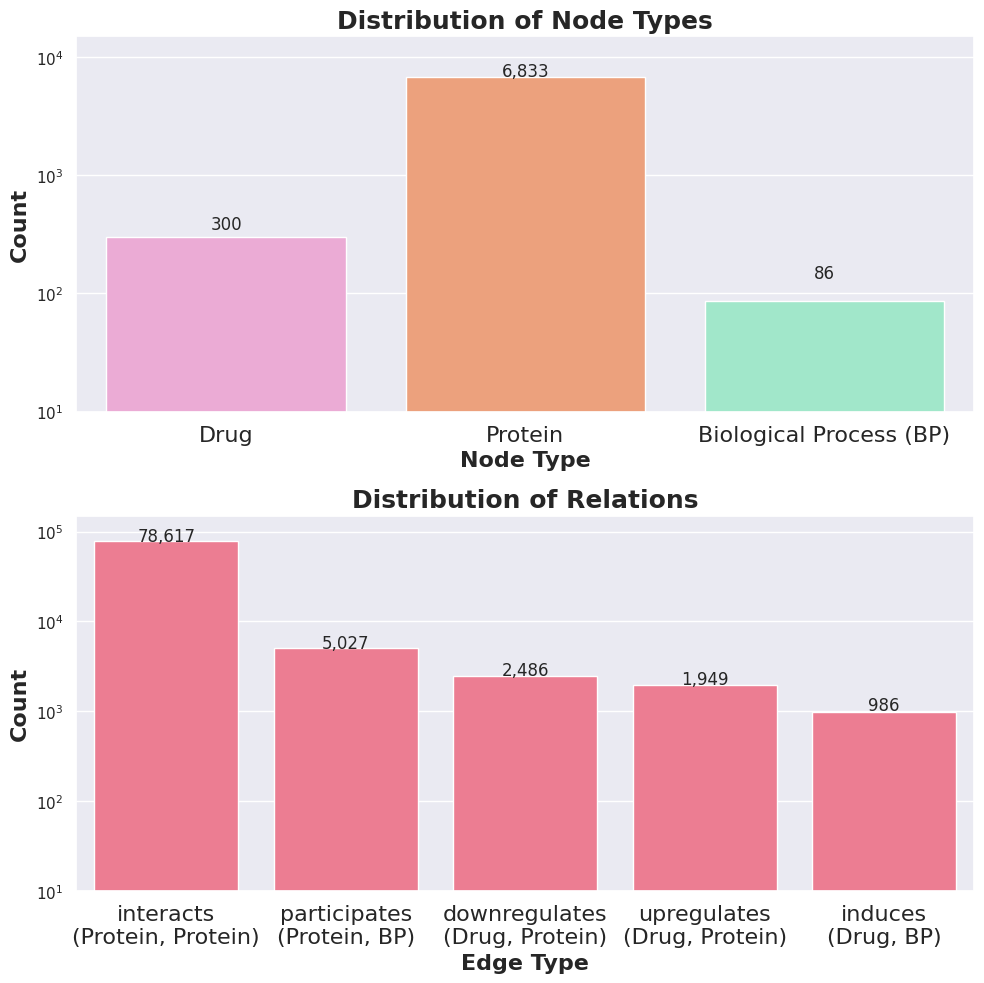

In [25]:
sns.set(rc={'figure.figsize':(10,10)})

# grid lines
sns.set_style("darkgrid")

plt.subplot(2, 1, 1)
bx1 = sns.barplot(
    x="Node Types", y="Count", data=node_df,
    palette=['#F6A0D8','#FE9A6B', '#95F3CC']
) 
plt.title(
    'Distribution of Node Types', 
    fontsize=18, 
    fontweight="bold"
)
plt.xlabel("Node Type", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.xticks(bx1.get_xticks(), labels=['Drug', 'Protein', 'Biological Process (BP)'], fontsize=16)
plt.ylim(10, 15000)
plt.yscale("log") #the log transformation

for p in bx1.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    bx1.text(_x, _y, f'{value:,}', ha="center") 

plt.subplot(2, 1, 2)
bx2 = sns.barplot(
    x="Edge Types", y="Count", data=edges_df, 
    color='#fe6b86'
)
plt.title(
    'Distribution of Relations', 
    fontsize=18, 
    fontweight="bold"
)
plt.xlabel("Edge Type", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold") 
plt.xticks(bx2.get_xticks(), labels=list(edges_df['Edge Types']), fontsize=16)
plt.ylim(10, 150000)

plt.yscale("log") #the log transformation

# Add counts above bars
for p in bx2.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    bx2.text(_x, _y, f'{value:,}', ha="center")   


plt.tight_layout()
plt.savefig(
    f'{FIG_DIR}/graph-stats-protclassed.png',
    dpi=400,
    bbox_inches='tight', 
)
plt.show()

In [26]:
ratio_interacts = edges_df.loc[edges_df['Edge Types']=='interacts\n(Protein, Protein)']['Count'].sum() / edges_df['Count'].sum()
ratio_interacts

0.8826924156514905